# Training ANN for predicting shear resistance of concrete beams reinforced by FRP bars

Reference: Shear resistance prediction of concrete beams reinforced by FRP bars using artificial neural networks
https://doi.org/10.1016/j.measurement.2018.05.051

The data from Table A1 of the above paper are saved into train_data.xlsx and loaded in this script for training an ANN using two different training algortihms: Adam and Levenberg-Marquardt. The data contains 6 input variables and one output variable. The latter is the shear resistance calculated according to ACI440.1R.

The fitting is done with a shallow neural network. This script is adjusted from the script published at https://github.com/fabiodimarco/tf-levenberg-marquardt . In this script it is shown that first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.


In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
# If the module levenberg_marquardt cannot be imported in Google Collab, then
# You can do this by clicking on the “Files” button on the left-hand side of the
# Colab interface, and then clicking on the “Upload” button. Once you have
# uploaded the module file (levenberg_marquardt.py), you can import it in your
# Colab notebook using a standard Python import statement.
import levenberg_marquardt as lm

In [2]:
input_size = 177 # Update this to match the size of your dataset
batch_size = 18
# Get the directory where this script is located
script_dir=os.getcwd()
print(script_dir)
# Construct the relative path to the Excel file
relative_file_path = 'train_data.xlsx'
excel_file_path = os.path.join(script_dir, relative_file_path)
print(excel_file_path)
# Load training data from Excel file If the data cannot be loaded in Google
# Collab, then upload the Excel file by clicking on the “Files” button on the
# left-hand side of the Colab interface, and then clicking on the “Upload”
# button.
train_data = pd.read_excel(excel_file_path, skiprows=0)
# Print dimensions of the data being loaded
print(train_data.shape)
# Separate input and output training data
x_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
# Print dimensions of the x data
print(x_train.shape)
# Print dimensions of the y data
print(y_train.shape)
print('Input data:')
print(x_train)
print('Output data:')
print(y_train)

# In order to develop improved performance of network, inputs and target
# parameters were normalized (mean = 0 and standard deviation = 1).
# (see in the paper the text below Figure 1)
# Normalize x data
# Calculate column means and standard deviations
x_train_means = np.mean(x_train, axis=0)
x_train_stds = np.std(x_train, axis=0)
#  Normalize each column
x_train = (x_train - x_train_means) / x_train_stds
print('Mean input values:')
print(x_train_means)
print('Standard deviation input values:')
print(x_train_stds)
print('Normalized input data:')
print(x_train)

# Normalize y data
# Calculate column means and standard deviations
y_train_means = np.mean(y_train, axis=0) # type: ignore
y_train_stds = np.std(y_train, axis=0) # type: ignore
#  Normalize each column
y_train = (y_train - y_train_means) / y_train_stds
print('Mean output values:')
print(y_train_means)
print('Standard deviation output values:')
print(y_train_stds)
print('Normalized output data:')
print(y_train)

# Split initial data into training and testing data based on randomly permuted
# indices 
# Generate a random permutation of indices
permuted_indices = np.random.permutation(x_train.shape[0])
# Define the split ratio (e.g., 80% to array_1, 20% to x_test)
split_ratio = 0.8
# Calculate the number of rows for each array based on the split ratio
split_index = int(split_ratio * x_train.shape[0])
# Split the indices
indices_array_1 = permuted_indices[:split_index]
indices_array_2 = permuted_indices[split_index:]
# X-data
x_test = x_train[indices_array_2]
x_train = x_train[indices_array_1]
# Y-data
y_test = y_train[indices_array_2]
y_train = y_train[indices_array_1]


c:\Users\gpapa\OneDrive\Desktop\10_GITHUB_REPOSITORIES_AND_CODE\tf-levenberg-marquardt-main
c:\Users\gpapa\OneDrive\Desktop\10_GITHUB_REPOSITORIES_AND_CODE\tf-levenberg-marquardt-main\train_data.xlsx
(177, 7)
(177, 6)
(177,)
Input data:
[[200.   325.     3.2   44.6    0.7  137.  ]
 [200.   325.     3.2   45.     0.7  137.  ]
 [200.   325.     3.2   46.9    0.9   58.  ]
 ...
 [150.   215.5    3.    40.3    0.44  41.  ]
 [150.   213.5    3.    40.3    0.44  40.  ]
 [150.   213.5    3.    40.3    0.44  40.  ]]
Output data:
[157.5312046  158.1569451  148.00991254 143.87835593 119.98278333
  71.72755404  82.13614676  84.35938465  87.51098658  86.41923261
 118.12378078  58.61330235  62.45185498 119.02613925  93.17489421
  80.39413928 102.76702262 102.76702262 102.76702262  83.03406416
  83.03406416  83.03406416 109.17473174 109.17473174 109.17473174
 134.50492596 134.50492596 134.50492596 123.74944419 123.74944419
 123.74944419 112.84443873 112.84443873 112.84443873  90.90884248
  80.5922938

In [3]:
# Convert data to TensorFlow tensors
x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
#print(x_train)
#print(y_train)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(input_size)
train_dataset = train_dataset.batch(batch_size).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [5]:
model = tf.keras.Sequential([
    #tf.keras.layers.Dense(20, activation='tanh', input_shape=(6,)), # lm works better with tanh than with sigmoid
    tf.keras.layers.Dense(7, activation='sigmoid', input_shape=(6,)),
    tf.keras.layers.Dense(1, activation='linear')])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError())

model_wrapper = lm.ModelWrapper(
    tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.MeanSquaredError())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 49        
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)
# loss value: 2.0443e-04

Train using Adam
Epoch 1/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.2872
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 0.8508
Epoch 3/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.6625
Epoch 4/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.5621
Epoch 5/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.4689
Epoch 6/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.3871
Epoch 7/1000
8/8 [==============================] - 0s 856us/step - loss: 0.3241
Epoch 8/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.2735
Epoch 9/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.2313
Epoch 10/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.1967
Epoch 11/1000
8/8 [==============================] - 0s 996us/step - loss: 0.1682
Epoch 12/1000
8/8 [==============================] - 0s 1ms/step - loss: 0.1445
Epoch 13/1000
8/8 [=========

In [7]:
print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=100)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)
#loss value: 2.3174e-05


_________________________________________________________________
Train using Levenberg-Marquardt
Epoch 1/100
8/8 [==============================] - 1s 37ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.6730
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.2061
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0805
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0410
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0280
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0232
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0208
Epoch 8/100



_________________________________________________________________
Plot results
2/2 [==============================] - 0s 5ms/step


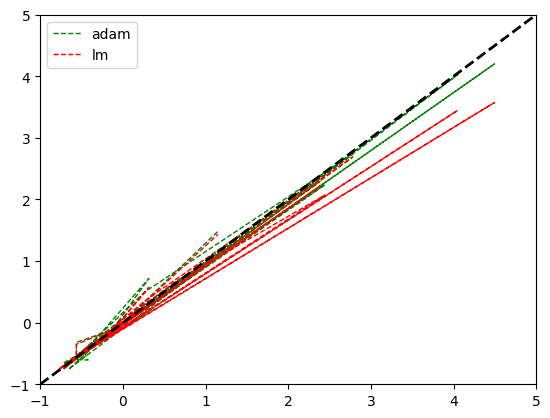

In [8]:
print("\n_________________________________________________________________")
print("Plot results")

plt.plot(y_test, model.predict(x_test), 'g--', label="adam", linewidth=1)
plt.plot(y_test, model_wrapper.predict(x_test), 'r--', label="lm", linewidth=1)
plt.legend()
#plt.axis('equal')
plt.xlim([-1, 5])  # Set your desired x-axis limits
plt.ylim([-1, 5])   # Set your desired y-axis limits
# Add a diagonal dashed line
x = np.linspace(-1, 5, 100)
y = x
plt.plot(x, y, linestyle='dashed', color='black', linewidth=2, label='Diagonal Line')

plt.show()


In [9]:
# Extract weights and biases from the input layer
input_layer_weights = model.layers[0].get_weights()[0]
input_layer_biases = model.layers[0].get_weights()[1]

# Extract weights and biases from the hidden layer
hidden_layer_weights = model.layers[1].get_weights()[0]
hidden_layer_biases = model.layers[1].get_weights()[1]

# Print the extracted weights and biases
print("Input layer weights:")
#print(input_layer_weights)
print(input_layer_weights.shape)
print("Input layer biases:")
#print(input_layer_biases)
print(input_layer_biases.shape)
print("Hidden layer weights:")
#print(hidden_layer_weights)
print(hidden_layer_weights.shape)
print("Hidden layer biases:")
#print(hidden_layer_biases)
print(hidden_layer_biases.shape)

Input layer weights:
(6, 7)
Input layer biases:
(7,)
Hidden layer weights:
(7, 1)
Hidden layer biases:
(1,)


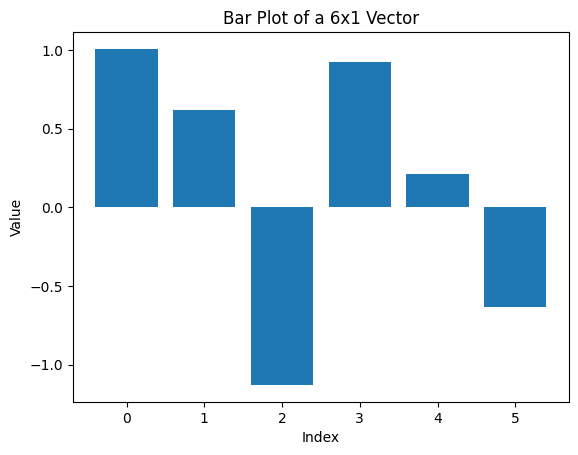

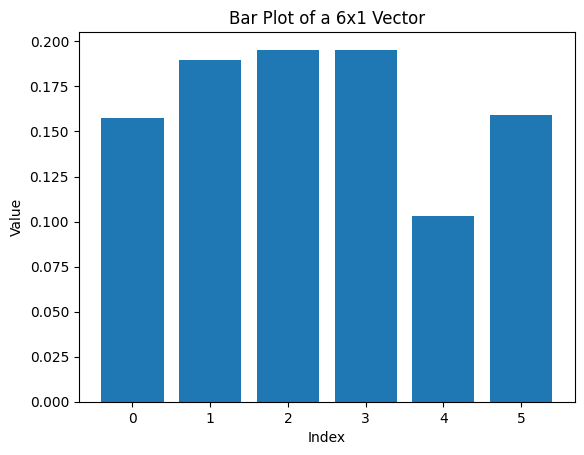

In [10]:
def garson(A, B):

    B = B.reshape(-1, 1)  # Reshape hidden_layer_weights to a column vector
    
    sum1 = np.sum(A, axis=0)
    sum2 = 0
    ri = np.zeros((1, A.shape[1]))

    for i in range(A.shape[1]):
        sum2 += np.dot(A[:, i], B[i, 0]) / sum1[i]

    ri = sum2 / np.sum(sum2)

    return ri


IF1=garson(input_layer_weights, hidden_layer_weights)
# Create an array of indices for the x-axis
x_indices = np.arange(len(IF1))
# Create the bar plot
plt.bar(x_indices, IF1)
# Customize plot labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Plot of a 6x1 Vector')
# Show the plot
plt.show()

IF2=garson(np.abs(input_layer_weights), np.abs(hidden_layer_weights))
# Create an array of indices for the x-axis
x_indices = np.arange(len(IF2))
# Create the bar plot
plt.bar(x_indices, IF2)
# Customize plot labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Plot of a 6x1 Vector')
# Show the plot
plt.show()

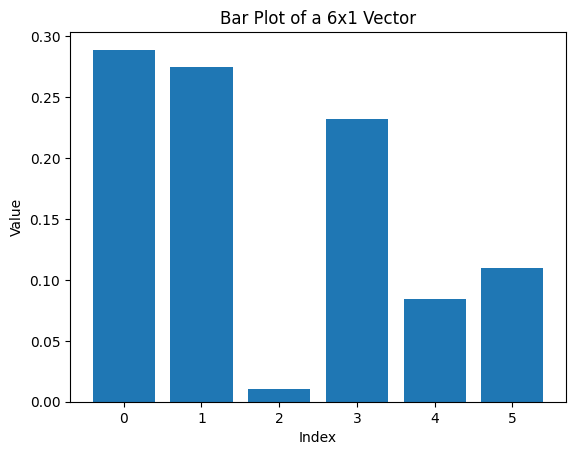

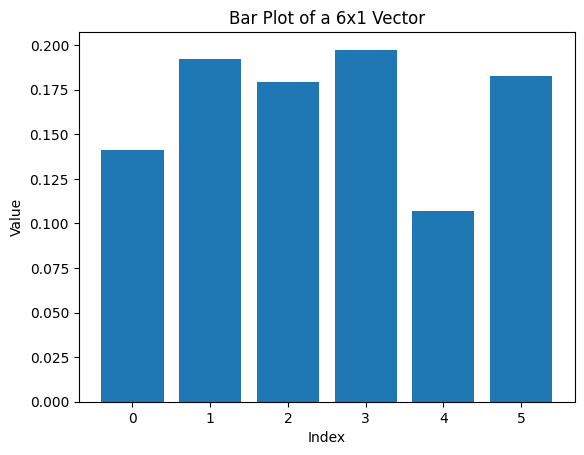

In [15]:
def garson2(A, B):
    
    #Computes Garson's algorithm
    #A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    #B = vector of weights of hidden-output layer

    B = B.reshape(-1, 1)  # Reshape hidden_layer_weights to a column vector
    #B = np.diag(B)

    # connection weight through the different hidden node
    cw = np.dot(A, B)

    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum(axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / np.sum(rc)
    return(ri)

IF1=garson2(input_layer_weights, hidden_layer_weights)
# Create an array of indices for the x-axis
x_indices = np.arange(len(IF1))
# Create the bar plot
plt.bar(x_indices, IF1)
# Customize plot labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Plot of a 6x1 Vector')
# Show the plot
plt.show()

IF2=garson2(np.abs(input_layer_weights), np.abs(hidden_layer_weights))
# Create an array of indices for the x-axis
x_indices = np.arange(len(IF2))
# Create the bar plot
plt.bar(x_indices, IF2)
# Customize plot labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Plot of a 6x1 Vector')
# Show the plot
plt.show()